In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!source /content/drive/MyDrive/colab_env/bin/activate

In [11]:
! pip install pyet swifter

In [27]:
import pandas as pd
import pyarrow
import pyet
import math
import datetime
import swifter
import numpy as np
import glob
import os
from sklearn.metrics import r2_score, mean_squared_error
import plotly.express as px

In [13]:
prism_data_daily = pd.read_parquet('/content/drive/MyDrive/EC_Tower/merged_prism_data_par_for_ameri_stations.parquet', engine='pyarrow')


In [14]:
# convert lat to radian
prism_data_daily["latitude_in_radian"] = list(map(math.radians, prism_data_daily["latitude"]))

prism_data_daily['time'] = pd.to_datetime(prism_data_daily['date'],format= "%Y-%m-%d" )

prism_data_daily.set_index('time', inplace=True)
prism_data_daily

,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,tmin,tmax,latitude,longitude,Site_ID,General_classification,Elevation,Energy_balance,Land_cover_details,Land_cover_type,latitude_in_radian
time,,,,,,,,,,,,,,,,,,,,
2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,4.565,6.442,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,4.836,7.053,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,4.656,7.567,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,0.441,9.665,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,0.316,8.929,36.4587,-119.5801,MB_Pch,Croplands,90.0,1.00,Peach,Orchards,0.636324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,6.817,16.126,38.2006,-122.0264,US-Srr,Wetland/Riparian,8.0,0.86,Brackish tidal marsh,Wetlands,0.666726
2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,4.567,14.088,38.2006,-122.0264,US-Srr,Wetland/Riparian,8.0,0.86,Brackish tidal marsh,Wetlands,0.666726
2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,4.429,13.631,38.2006,-122.0264,US-Srr,Wetland/Riparian,8.0,0.86,Brackish tidal marsh,Wetlands,0.666726


In [15]:
# Solar Constant [ MJ m-2 min-1]
SOLAR_CONSTANT = 0.0820

def standard_date_to_Julian_day (
    standard_date_in_gregorian : str
    ) -> int:

    """
    Description
    -----------
    calculate Julian Day with standard date
    Ref:https://rafatieppo.github.io/post/2018_12_01_juliandate/
    ----------

    standard_date_in_gregorian : str
        Date with the specified standard

    Returns
    -------
    Julian Day : int
        Number of days of the year taking into account the leap year
    """

    fmt='%Y-%m-%d'
    sdtdate = datetime.datetime.strptime(standard_date_in_gregorian, fmt)
    sdtdate = sdtdate.timetuple()
    jdate = sdtdate.tm_yday

    return(jdate)


def inverse_relative_distance_earth_sun(
    julian_date: int
) -> float:

    """
    Description
    -----------
    calculate Inverse Relative Distance Earth Sun With Julian Date - eq 23 FAO56
    ----------


    Julian Day : int
        Number of days of the year taking into account the leap year

    Returns
    -------
    inverse_relative_distance_earth_sun : float
        inverse relative distance earth sun in Radian
    """

    return 1 + (0.033 * np.cos((2 * np.pi * julian_date)/365))

def solar_declination(
    julian_date: int
) -> float:

    """
    Description
    -----------
    calculate Solar Declination With Julian Date - eq 24 FAO56
    ----------

    julian_date : int
        Number of days of the year taking into account the leap year

    Returns
    -------
    solar_declination : float
        solar_declination in Radian
    """

    return 0.409 * np.sin(((2 * np.pi * julian_date) / 365) - 1.39)

def sunset_hour_angle(
    latitude : float,
    solar_declination : float
) -> float:

    """
    Description
    -----------
    calculate Sunset Hour Angle With Latitude and Solar Declination - eq 25 FAO56
    ----------

    latitude: float
        latitude in Radian
    solar_declination : float
        solar_declination in Radian

    Returns
    -------
    sunset_hour_angle : float
        sunset hour angle in Radian
    """

    return np.arccos(-np.tan(latitude) * np.tan(solar_declination))

def extraterrestrial_radiation(
    inverse_relative_distance_earth_sun : float,
    sunset_hour_angle : float,
    latitude : float,
    solar_declination : float
) -> float:

    """
    Description
    -----------
    calculate Extraterrestrial Radiation - eq 28 FAO56
    ----------

    inverse_relative_distance_earth_sun : float
        inverse relative distance earth sun in Radian
    sunset_hour_angle : float
        sunset hour angle in Radian
    latitude: float
        latitude in Radian
    solar_declination : float
        solar_declination in Radian

    Returns
    -------
    extraterrestrial_radiation : float
            extraterrestrial radiation in MJ/m**2/day
    """

    temp_1 = ((24 * 60 )/ np.pi) * SOLAR_CONSTANT * inverse_relative_distance_earth_sun

    temp_2 = sunset_hour_angle * np.sin(latitude) * np.sin(solar_declination)

    temp_3 = np.cos(latitude)* np.cos(solar_declination) * np.sin(sunset_hour_angle)

    return temp_1 * (temp_2 + temp_3)

def solar_or_Short_wave_Radiation_Hargreaves(
    extraterrestrial_radiation : float,
    tmax : float,
    tmin : float,
    Adjustment_coefficient_or_K_RS : float
)-> float:

    """
    Description
    -----------
    calculate Solar or shortwave radiation with max and min Tempreture - eq 50 FAO56
    ----------

    extraterrestrial_radiation : float
        extraterrestrial radiation in MJ/m**2/day
    tmax : float
        Maximum Temperature in celsius
    tmin : float
        Minimum Temperature in celsius
    Adjustment_coefficient_or_K_RS : float
        Adjustment coefficient in C**-0.5 -- between 0.16 to 0.19
            for interior locations, where land mass dominates and air masses are not strongly
            influenced by a large water body, kRs ≅ 0.16;
            for coastal locations, situated on or adjacent to the coast of a large land mass and where
            air masses are influenced by a nearby water body, kRs ≅ 0.19

    Returns
    -------
    Solar or shortwave radiation : float
        Solar or shortwave radiation in MJ/m**2/day
    """
    temp_1 = extraterrestrial_radiation


    return Adjustment_coefficient_or_K_RS * np.sqrt(tmax - tmin) * temp_1

In [16]:
Adjustment_coefficient_or_K_RS = 0.175

# array_Date = prism_data_daily.date.to_numpy()

# array_latitude = prism_data_daily.latitude_in_radian.to_numpy()

# array_tmin = prism_data_daily["tmin"].to_numpy()

# array_tmax = prism_data_daily["tmax"].to_numpy()


# julian_day = np.vectorize(standard_date_to_Julian_day)(array_Date)
# dr = np.vectorize(inverse_relative_distance_earth_sun)(julian_day)

# delta = np.vectorize(solar_declination)(julian_day)

# omega_s = np.vectorize(sunset_hour_angle)(array_latitude, delta)

# ra = np.vectorize(extraterrestrial_radiation)(dr, omega_s, array_latitude, delta)

# rs = np.vectorize(solar_or_Short_wave_Radiation_Hargreaves)(ra, array_tmax, array_tmin, Adjustment_coefficient_or_K_RS)



prism_data_daily['julian_day'] = prism_data_daily.apply(lambda row: standard_date_to_Julian_day(row['date']), axis=1)
prism_data_daily['dr'] = prism_data_daily.apply(lambda row: inverse_relative_distance_earth_sun(row['julian_day']), axis=1)
prism_data_daily['delta'] = prism_data_daily.apply(lambda row: solar_declination(row['julian_day']), axis=1)
prism_data_daily['omega_s'] = prism_data_daily.apply(lambda row: sunset_hour_angle(row['latitude_in_radian'], row["delta"]), axis=1)
prism_data_daily['ra'] = prism_data_daily.apply(lambda row: extraterrestrial_radiation(row['dr'], row["omega_s"], row["latitude_in_radian"], row["delta"]), axis=1)
prism_data_daily['rs'] = prism_data_daily.apply(lambda row: solar_or_Short_wave_Radiation_Hargreaves(row['ra'], row["tmax"], row["tmin"], Adjustment_coefficient_or_K_RS), axis=1)

# Append each array as a new column
# prism_data_daily['julian_day'] = julian_day
# prism_data_daily['dr'] = dr
# prism_data_daily['delta'] = delta
# prism_data_daily['omega_s'] = omega_s
# prism_data_daily['ra'] = ra
# prism_data_daily['rs'] = rs
prism_data_daily

,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,tmin,...,Energy_balance,Land_cover_details,Land_cover_type,latitude_in_radian,julian_day,dr,delta,omega_s,ra,rs
time,,,,,,,,,,,,,,,,,,,,,
2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,4.565,...,1.00,Peach,Orchards,0.636324,366,1.032995,-0.401008,1.252175,16.025685,3.842260
2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,4.836,...,1.00,Peach,Orchards,0.636324,1,1.032995,-0.401008,1.252175,16.025685,4.175779
2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,4.656,...,1.00,Peach,Orchards,0.636324,2,1.032980,-0.399564,1.253500,16.080602,4.801329
2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,0.441,...,1.00,Peach,Orchards,0.636324,3,1.032956,-0.398001,1.254930,16.139901,8.578247
2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,0.316,...,1.00,Peach,Orchards,0.636324,4,1.032922,-0.396320,1.256466,16.203566,8.321965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,6.817,...,0.86,Brackish tidal marsh,Wetlands,0.666726,361,1.032922,-0.406440,1.225258,14.737636,7.868961
2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,4.567,...,0.86,Brackish tidal marsh,Wetlands,0.666726,362,1.032956,-0.405594,1.226097,14.770615,7.975867
2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,4.429,...,0.86,Brackish tidal marsh,Wetlands,0.666726,363,1.032980,-0.404627,1.227054,14.808078,7.861001


In [17]:
# prism_data_daily["blaney_criddle"] = pyet.blaney_criddle(
#     tmean = prism_data_daily["tmean"],
#     lat = prism_data_daily["latitude_in_radian"]
# )

# prism_data_daily["hamon"] = pyet.hamon(
#     tmean = prism_data_daily["tmean"],
#     lat = prism_data_daily["latitude_in_radian"]
# )

prism_data_daily["oudin"] = pyet.oudin(
    tmean = prism_data_daily["tmean"],
    lat = prism_data_daily["latitude_in_radian"]
)

prism_data_daily["hargreaves"] = pyet.hargreaves(
    tmean = prism_data_daily["tmean"],
    tmax = prism_data_daily["tmax"],
    tmin = prism_data_daily["tmin"],
    lat = prism_data_daily["latitude_in_radian"]
)

prism_data_daily["abtew"] = pyet.abtew(
    tmean = prism_data_daily["tmean"],
    rs = prism_data_daily["rs"]
)


prism_data_daily["mcguinness_bordne"] = pyet.mcguinness_bordne(
    tmean = prism_data_daily["tmean"],
    lat = prism_data_daily["latitude_in_radian"]
)

# prism_data_daily["jensen_haise"] = pyet.jensen_haise(
#     tmean = prism_data_daily["tmean"],
#     lat = prism_data_daily["latitude_in_radian"]
# )
prism_data_daily = prism_data_daily.reset_index()

In [18]:
# Specify the directory path and file pattern

file_path = '/content/drive/MyDrive/EC_Tower/stations/*.csv'
csv_files = glob.glob(file_path)

dfs = []

for file in csv_files:

    ts_data = pd.read_csv(file)

    ts_data["Site_ID"] = file.removesuffix("_daily_data.csv")[41:]

    dfs.append(ts_data)

merged_df = pd.concat(dfs, ignore_index=True)
merged_df



,date,rh,H,sw_in,t_dew,vp,theta_1,lw_out,LE,wd,...,ET_gap,ET_fill_val,Site_ID,H_qc_flag,Rn_qc_flag,LE_qc_flag,t_avg_qc_flag,vpd_qc_flag,G_qc_flag,ppt
0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,US-Tw2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20138,2018-05-31,58.591875,74.299147,346.442861,11.252931,1.361338,26.386760,404.013732,60.627478,242.604626,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
20139,2018-06-01,54.740417,57.072189,354.218242,12.342688,1.462196,26.324656,420.252554,75.335373,282.614125,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
20140,2018-06-02,45.873125,34.105066,356.110903,12.915099,1.533126,26.316750,438.610560,109.118007,238.779884,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
20141,2018-06-03,47.508958,15.475881,353.838460,13.621733,1.604567,26.276646,443.144378,122.170050,225.033641,...,False,NaN,US-Tw3,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [19]:



# Merge the DataFrames
result = pd.merge(prism_data_daily, merged_df[['date', 'Site_ID', 'ET_fill']],
                  on=['date', 'Site_ID'],
                  how='left')

result

,time,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,...,dr,delta,omega_s,ra,rs,oudin,hargreaves,abtew,mcguinness_bordne,ET_fill
0,2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,...,1.032995,-0.401008,1.252175,16.025685,3.842260,0.676516,0.472973,0.818486,0.994479,NaN
1,2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,...,1.032995,-0.401008,1.252175,16.025685,4.175779,0.705217,0.523976,0.889905,1.036669,NaN
2,2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,...,1.032980,-0.399564,1.253500,16.080602,4.801329,0.718546,0.606803,1.023379,1.056262,NaN
3,2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,...,1.032956,-0.398001,1.254930,16.139901,8.578247,0.651802,1.035083,1.826573,0.958149,NaN
4,2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,...,1.032922,-0.396320,1.256466,16.203566,8.321965,0.626125,0.984862,1.771280,0.920404,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56974,2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,...,1.032922,-0.406440,1.225258,14.737636,7.868961,0.981236,1.223674,1.685809,1.442417,NaN
56975,2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,...,1.032956,-0.405594,1.226097,14.770615,7.975867,0.853682,1.147109,1.705223,1.254913,NaN
56976,2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,...,1.032980,-0.404627,1.227054,14.808078,7.861001,0.837833,1.117869,1.680189,1.231615,NaN
56977,2020-12-29,12_20201230,2020-12-29,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",-1.101,9.277900,15.402,0.592,...,1.032995,-0.403540,1.228128,14.850017,10.391113,0.855260,1.491673,2.221492,1.257232,NaN


In [20]:
result.columns

Index(['time', 'system:index', 'date', 'point_id', 'ppt', '.geo', 'tdmean',
       'tmean', 'vpdmax', 'vpdmin', 'tmin', 'tmax', 'latitude', 'longitude',
       'Site_ID', 'General_classification', 'Elevation', 'Energy_balance',
       'Land_cover_details', 'Land_cover_type', 'latitude_in_radian',
       'julian_day', 'dr', 'delta', 'omega_s', 'ra', 'rs', 'oudin',
       'hargreaves', 'abtew', 'mcguinness_bordne', 'ET_fill'],
      dtype='object')

In [21]:
result.describe()

,time,point_id,ppt,tdmean,tmean,vpdmax,vpdmin,tmin,tmax,latitude,...,dr,delta,omega_s,ra,rs,oudin,hargreaves,abtew,mcguinness_bordne,ET_fill
count,56979,56979.00000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,...,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,56979.000000,19223.000000
mean,2014-12-31 00:00:00.000000256,7.00000,0.891576,7.897984,16.623717,21.531063,2.246428,9.439106,23.809202,37.511977,...,1.000023,-0.000274,1.570569,29.091552,19.463669,2.754683,3.819833,4.199498,4.049384,3.162290
min,2008-12-31 00:00:00,1.00000,0.000000,-13.208000,1.104000,0.038000,0.000000,-6.560000,3.365000,36.169700,...,0.967001,-0.408985,1.221578,14.577966,1.598166,0.374564,0.248975,0.342400,0.550609,-0.043735
25%,2011-12-31 00:00:00,4.00000,0.000000,5.163000,11.113001,9.615000,0.487000,5.272000,17.013000,36.839000,...,0.976615,-0.289815,1.339182,19.490798,12.174820,1.295079,1.837494,2.606673,1.903766,1.157498
50%,2014-12-31 00:00:00,7.00000,0.000000,8.488000,16.406000,17.687000,1.340000,9.750000,23.451000,38.099200,...,1.000142,0.001741,1.572098,29.807825,19.523281,2.601264,3.540588,4.201942,3.823858,2.556236
75%,2017-12-31 00:00:00,10.00000,0.000000,11.204500,21.869501,30.971000,2.941500,13.575000,30.428000,38.109000,...,1.023183,0.287347,1.800358,38.666840,26.576752,4.078145,5.588231,5.749389,5.994874,4.774055
max,2020-12-30 00:00:00,13.00000,110.868000,19.289000,34.281002,83.315000,22.538000,26.610000,44.267000,38.289000,...,1.033000,0.409000,1.920030,41.817125,37.859995,6.578623,9.150822,8.233124,9.670576,16.182688
std,NaN,3.74169,3.553854,4.315210,6.549320,14.819296,2.606275,5.496060,8.101028,0.812924,...,0.023343,0.289300,0.235466,9.535865,7.986865,1.512359,2.113908,1.741747,2.223168,2.374425


In [22]:
def budyko(pet, p):
    # from Budyko 1958
    # p,pet = X
    if p == 0:
        x = 0
    else:
        # x = (1 + (0.5 * (pet / p)** (-1.5)))**(-1)
        x = math.sqrt(((pet/p)*math.tanh(p/pet))*(1-math.exp(-pet/p)))
    return x


def aet(ratio, p):
  return ratio * p

In [23]:
# array_p = result["ppt"].to_numpy()

# array_pet_oudin = result["oudin"].to_numpy()
# array_pet_hargreaves = result["hargreaves"].to_numpy()
# array_pet_abtew = result["abtew"].to_numpy()
# array_pet_mcguinness_bordne = result["mcguinness_bordne"].to_numpy()



# ratio_budyko_oudin = np.vectorize(budyko)(array_pet_oudin, array_p)
# aet_budyko_oudin = np.vectorize(lambda r, p: r * p)(r = ratio_budyko_oudin, p = array_p)

# ratio_budyko_hargreaves = np.vectorize(budyko)(array_pet_hargreaves, array_p)
# aet_budyko_hargreaves = np.vectorize(lambda r, p: r * p)(r = ratio_budyko_hargreaves, p = array_p)

# ratio_budyko_abtew = np.vectorize(budyko)(array_pet_abtew, array_p)
# aet_budyko_abtew = np.vectorize(lambda r, p: r * p)(r = ratio_budyko_abtew, p = array_p)

# ratio_budyko__mcguinness_bordne = np.vectorize(budyko)(array_pet_mcguinness_bordne, array_p)
# aet_budyko__mcguinness_bordne = np.vectorize(lambda r, p: r * p)(r = ratio_budyko__mcguinness_bordne, p = array_p)



result['ratio_budyko_oudin'] = result.apply(lambda row: budyko(row['oudin'], row["ppt"]), axis=1)

result['aet_budyko_oudin'] = result.apply(lambda row: aet(row['ratio_budyko_oudin'], row["ppt"]), axis=1)


result['ratio_budyko_hargreaves'] = result.apply(lambda row: budyko(row['hargreaves'], row["ppt"]), axis=1)

result['aet_budyko_hargreaves'] = result.apply(lambda row: aet(row['ratio_budyko_hargreaves'], row["ppt"]), axis=1)


result['ratio_budyko_abtew'] = result.apply(lambda row: budyko(row['abtew'], row["ppt"]), axis=1)

result['aet_budyko_abtew'] = result.apply(lambda row: aet(row['ratio_budyko_abtew'], row["ppt"]), axis=1)


result['ratio_budyko_mcguinness_bordne'] = result.apply(lambda row: budyko(row['mcguinness_bordne'], row["ppt"]), axis=1)

result['aet_budyko_mcguinness_bordne'] = result.apply(lambda row: aet(row['ratio_budyko_mcguinness_bordne'], row["ppt"]), axis=1)


result

# result['aet_budyko_oudin'] = aet_budyko_oudin
# result['aet_budyko_hargreaves'] = aet_budyko_hargreaves
# result['aet_budyko_abtew'] = aet_budyko_abtew
# result['aet_budyko__mcguinness_bordne'] = aet_budyko__mcguinness_bordne


,time,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,...,mcguinness_bordne,ET_fill,ratio_budyko_oudin,aet_budyko_oudin,ratio_budyko_hargreaves,aet_budyko_hargreaves,ratio_budyko_abtew,aet_budyko_abtew,ratio_budyko_mcguinness_bordne,aet_budyko_mcguinness_bordne
0,2008-12-31,0_20090101,2008-12-31,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.717,5.503000,0.912,0.239,...,0.994479,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2009-01-01,0_20090102,2009-01-01,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.025,5.944000,1.700,0.494,...,1.036669,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2009-01-02,0_20090103,2009-01-02,1,2.898,"{""type"":""MultiPoint"",""coordinates"":[]}",4.454,6.111000,2.067,0.370,...,1.056262,NaN,0.233268,0.676011,0.198876,0.576341,0.323011,0.936085,0.332279,0.962946
3,2009-01-03,0_20090104,2009-01-03,1,0.228,"{""type"":""MultiPoint"",""coordinates"":[]}",3.300,5.052000,3.851,0.202,...,0.958149,NaN,0.951844,0.217020,0.986726,0.224974,0.997250,0.227373,0.983290,0.224190
4,2009-01-04,0_20090105,2009-01-04,1,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",1.732,4.622000,3.458,0.290,...,0.920404,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56974,2020-12-26,12_20201227,2020-12-26,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",6.645,11.471399,8.840,0.435,...,1.442417,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
56975,2020-12-27,12_20201228,2020-12-27,13,1.227,"{""type"":""MultiPoint"",""coordinates"":[]}",4.315,9.327499,7.957,0.464,...,1.254913,NaN,0.558132,0.684828,0.669477,0.821448,0.802162,0.984252,0.701850,0.861170
56976,2020-12-28,12_20201229,2020-12-28,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",4.685,9.029900,6.475,0.323,...,1.231615,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
56977,2020-12-29,12_20201230,2020-12-29,13,0.000,"{""type"":""MultiPoint"",""coordinates"":[]}",-1.101,9.277900,15.402,0.592,...,1.257232,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
# Assuming your DataFrame is named 'df' and the two columns are 'actual' and 'predicted'
def calculate_metrics(df, actual_col, predicted_col):
    actual = df[actual_col]
    predicted = df[predicted_col]

    r2 = r2_score(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    nse = 1 - (np.sum((actual - predicted) ** 2) / np.sum((actual - np.mean(actual)) ** 2))

    nrmse = rmse / (np.max(actual) - np.min(actual))

    return r2, rmse, nse, nrmse

In [39]:
filtered_df = result[result['ET_fill'].apply(lambda x: isinstance(x, float) and not np.isnan(x))]

filtered_df = filtered_df[filtered_df['ratio_budyko_hargreaves'].apply(lambda x: isinstance(x, float) and not np.isnan(x))]

filtered_df = filtered_df[filtered_df['ratio_budyko_hargreaves'].apply(lambda x: isinstance(x, float) and x != 0)]

filtered_df = filtered_df[filtered_df['point_id'].apply(lambda x: x ==1)]

# filtered_df = filtered_df[filtered_df['ppt'].apply(lambda x: isinstance(x, float) and x != 0)]



r2, rmse, nse, nrmse = calculate_metrics(filtered_df, 'ET_fill', 'aet_budyko_hargreaves')

print(f"R-squared: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"NSE: {nse:.4f}")
print(f"NRMSE: {nrmse:.4f}")


R-squared: 0.0092
RMSE: 1.3225
NSE: 0.0092
NRMSE: 0.1917


In [26]:
filtered_df

,time,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,...,mcguinness_bordne,ET_fill,ratio_budyko_oudin,aet_budyko_oudin,ratio_budyko_hargreaves,aet_budyko_hargreaves,ratio_budyko_abtew,aet_budyko_abtew,ratio_budyko_mcguinness_bordne,aet_budyko_mcguinness_bordne
1196,2012-04-10,0_20120411,2012-04-10,1,6.001,"{""type"":""MultiPoint"",""coordinates"":[]}",4.425,14.785001,21.252,0.976,...,4.103000,3.601669,0.410319,2.462327,0.567987,3.408489,0.648639,3.892481,0.551484,3.309454
1197,2012-04-11,0_20120412,2012-04-11,1,9.757,"{""type"":""MultiPoint"",""coordinates"":[]}",8.323,11.087001,5.661,0.561,...,3.343019,2.424285,0.220094,2.147459,0.253681,2.475161,0.343720,3.353678,0.314352,3.067134
1198,2012-04-12,0_20120413,2012-04-12,1,13.397,"{""type"":""MultiPoint"",""coordinates"":[]}",8.008,11.266001,6.858,1.009,...,3.399453,2.327114,0.165428,2.216234,0.197222,2.642178,0.268161,3.592554,0.238380,3.193575
1199,2012-04-13,0_20120414,2012-04-13,1,16.407,"{""type"":""MultiPoint"",""coordinates"":[]}",7.152,9.398001,3.052,0.462,...,3.019986,2.049389,0.121396,1.991747,0.111328,1.826559,0.162851,2.671896,0.175909,2.886146
1211,2012-04-25,0_20120426,2012-04-25,1,3.982,"{""type"":""MultiPoint"",""coordinates"":[]}",14.434,20.447000,17.624,0.806,...,5.712635,2.962212,0.685092,2.728037,0.734246,2.923769,0.751948,2.994257,0.811450,3.231196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2015-12-18,0_20151219,2015-12-18,1,0.012,"{""type"":""MultiPoint"",""coordinates"":[]}",0.992,6.793000,10.322,0.220,...,1.096860,0.691575,0.999957,0.011999,0.999989,0.012000,0.999996,0.012000,0.999980,0.012000
2544,2015-12-19,0_20151220,2015-12-19,1,14.615,"{""type"":""MultiPoint"",""coordinates"":[]}",4.572,4.613000,2.088,0.220,...,0.891833,0.507731,0.041084,0.600447,0.059959,0.876298,0.106594,1.557868,0.060103,0.878399
2546,2015-12-21,0_20151222,2015-12-21,1,10.641,"{""type"":""MultiPoint"",""coordinates"":[]}",7.017,9.459001,7.238,0.419,...,1.347491,0.521783,0.084322,0.897269,0.109532,1.165531,0.159915,1.701655,0.122727,1.305936
2547,2015-12-22,0_20151223,2015-12-22,1,0.588,"{""type"":""MultiPoint"",""coordinates"":[]}",10.721,13.332001,5.206,0.374,...,1.715416,0.731655,0.892350,0.524702,0.920628,0.541329,0.956772,0.562582,0.954222,0.561083


In [42]:
filtered_df.to_csv('/content/drive/MyDrive/EC_Tower/final_et.csv')

In [31]:
import plotly.io as pio
pio.renderers.default = "colab"

In [33]:
import matplotlib.pyplot as plt

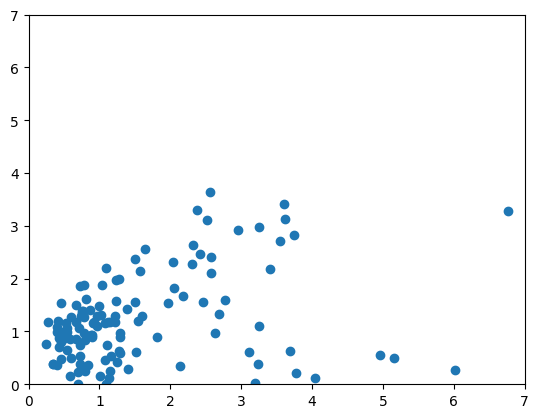

In [35]:
plt.scatter(filtered_df["ET_fill"], filtered_df["aet_budyko_hargreaves"])
# set axes range
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.show()

In [32]:

fig = px.scatter(filtered_df["ET_fill"], filtered_df["aet_budyko_hargreaves"])
fig.show(renderer="colab")

In [ ]:
pppet = filtered_df["hargreaves"][1196]
pppt = filtered_df["ppt"][1196]

ratio_fraction = budyko(
    pet = pppet,
    p = pppt
)
aet = ratio_fraction * pppt
aet

3.281333742184256

In [ ]:
filtered_df['result'] = filtered_df.apply(lambda row: budyko(row['hargreaves'], row['ppt']), axis=1)
filtered_df


,time,system:index,date,point_id,ppt,.geo,tdmean,tmean,vpdmax,vpdmin,...,oudin,hargreaves,abtew,mcguinness_bordne,ET_fill,aet_budyko_oudin,aet_budyko_hargreaves,aet_budyko_abtew,aet_budyko__mcguinness_bordne,result
1196,2012-04-10,0_20120411,2012-04-10,1,6.001,"{""type"":""MultiPoint"",""coordinates"":[]}",4.425,14.785001,21.252,0.976,...,2.791157,4.284434,5.302270,4.103000,3.601669,0.0,0.0,0.0,0.0,0.546798
1197,2012-04-11,0_20120412,2012-04-11,1,9.757,"{""type"":""MultiPoint"",""coordinates"":[]}",8.323,11.087001,5.661,0.561,...,2.274162,2.646425,3.694394,3.343019,2.424285,0.0,0.0,0.0,0.0,0.220283
1198,2012-04-12,0_20120413,2012-04-12,1,13.397,"{""type"":""MultiPoint"",""coordinates"":[]}",8.008,11.266001,6.858,1.009,...,2.312553,2.780581,3.857771,3.399453,2.327114,0.0,0.0,0.0,0.0,0.159037
1199,2012-04-13,0_20120414,2012-04-13,1,16.407,"{""type"":""MultiPoint"",""coordinates"":[]}",7.152,9.398001,3.052,0.462,...,2.054412,1.879101,2.786116,3.019986,2.049389,0.0,0.0,0.0,0.0,0.071943
1211,2012-04-25,0_20120426,2012-04-25,1,3.982,"{""type"":""MultiPoint"",""coordinates"":[]}",14.434,20.447000,17.624,0.806,...,3.886146,4.471146,4.714195,5.712635,2.962212,0.0,0.0,0.0,0.0,0.704108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55676,2017-06-07,12_20170608,2017-06-07,13,1.380,"{""type"":""MultiPoint"",""coordinates"":[]}",10.225,18.756000,18.233,2.337,...,4.019611,4.890679,5.395064,5.908828,5.428622,0.0,0.0,0.0,0.0,0.930281
55677,2017-06-08,12_20170609,2017-06-08,13,0.003,"{""type"":""MultiPoint"",""coordinates"":[]}",12.818,17.500000,9.714,1.295,...,3.805932,3.505136,4.004205,5.594720,1.961380,0.0,0.0,0.0,0.0,0.999987
55679,2017-06-10,12_20170611,2017-06-10,13,2.504,"{""type"":""MultiPoint"",""coordinates"":[]}",6.966,16.641000,17.702,2.935,...,3.663386,4.750406,5.562129,5.385177,5.301356,0.0,0.0,0.0,0.0,0.839385
55680,2017-06-11,12_20170612,2017-06-11,13,0.581,"{""type"":""MultiPoint"",""coordinates"":[]}",7.103,14.738001,16.461,0.570,...,3.337412,4.598271,5.698883,4.905995,4.792554,0.0,0.0,0.0,0.0,0.978037


In [ ]:
result["ET_fill"][56978]

nan

In [ ]:
#  Create a new column for the month


prism_data_daily["month"] = prism_data_daily['time'].dt.month
prism_data_daily["year"] = prism_data_daily['time'].dt.year


# 3. Group by month and site_id, then aggregate the data
monthly_data = prism_data_daily.groupby(['Site_ID', 'month']).agg({
    'oudin' : 'sum',
    'hargreaves' : 'sum',
    'abtew' : 'sum',
    'mcguinness_bordne' : 'sum',
}).reset_index()

monthly_data


,Site_ID,month,oudin,hargreaves,abtew,mcguinness_bordne
0,Almond_High,1,375.020823,548.225800,819.061030,551.280609
1,Almond_High,2,493.201590,733.431161,1023.386044,725.006338
2,Almond_High,3,824.282827,1192.996944,1515.707979,1211.695756
3,Almond_High,4,1139.804574,1641.487014,1897.620580,1675.512724
4,Almond_High,5,1530.637136,2145.317166,2258.402792,2250.036589
...,...,...,...,...,...,...
151,US-Twt,8,1547.226640,2057.531040,2037.938899,2274.423160
152,US-Twt,9,1199.531034,1614.082477,1633.649185,1763.310620
153,US-Twt,10,802.784104,1109.185993,1248.189646,1180.092633
154,US-Twt,11,430.600646,619.509636,836.241525,632.982950
